In [122]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [123]:
from IPython.display import display
pd.options.display.max_columns = None #show all columns

In [124]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [125]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [126]:
train_df.dtypes.head()

Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
dtype: object

In [127]:
x = train_df.columns.to_series().groupby(train_df.dtypes).groups
x , x.keys()

({dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
         'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
         'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
         'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
         'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
         'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
         'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
        dtype='object'),
  dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
  dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
         'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
         'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
         'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       

In [128]:
#list(enumerate(train_df.columns))

In [129]:
x2  = pd.Series(train_df.columns.to_series().groupby(train_df.dtypes))
print('  ',x2.iloc[0][0],':',len(x2.iloc[0][1]),'\n', 
      x2.iloc[1][0],':',len(x2.iloc[1][1]),'\n ',
      x2.iloc[2][0],':', len(x2.iloc[2][1])) #37 variables either int or float

   int64 : 35 
 float64 : 3 
  object : 43


In [130]:
xint = x2.iloc[0][1].tolist() 
xfloat = x2.iloc[1][1].tolist() 

In [131]:
xint, xfloat, len(xint+xfloat)

(['Id',
  'MSSubClass',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold',
  'SalePrice'],
 ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'],
 38)

In [132]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [133]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [134]:
train_numeric = train_df._get_numeric_data() #keep only numeric features
#print(len(train_numeric))
corr_matrix = train_df.corr()
print(len(corr_matrix))
corr_matrix.SalePrice.sort_values(ascending=False).drop(['SalePrice'])

38


OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [135]:
train_ID = train_df['Id']
test_ID = test_df['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

In [136]:
train_df.shape, test_df.shape

((1460, 80), (1459, 79))

In [137]:
y_train = train_df['SalePrice']
X_train = train_df.drop('SalePrice', axis=1)
X_test = test_df.copy()

In [138]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [139]:
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [140]:
y_train.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [141]:
print(X_train.shape)
print(X_test.shape)

(1460, 79)
(1459, 79)


In [142]:
all_data = pd.concat([X_train, X_test], ignore_index=True)
all_data.shape

(2919, 79)

## Imputing missing values 

In [143]:
all_data.isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
LotFrontage       486
GarageCond        159
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
BsmtFinSF2          1
BsmtFinSF1          1
Exterior2nd         1
BsmtUnfSF           1
TotalBsmtSF         1
Exterior1st         1
SaleType            1
                 ... 
YearRemodAdd        0
YearBuilt           0
SaleCondition       0
HeatingQC           0
ExterQual           0
ExterCond           0
YrSold              0
MoSold              0
MiscVal             0
PoolArea            0
ScreenPorch         0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
WoodDeckSF

In [144]:
all_data['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [145]:
#BsmtExposure       38
#BsmtFinType2       38
#BsmtFinType1       37
#BsmtCond           37
#BsmtQual           37

In [146]:
#before
print(all_data['BsmtExposure'].unique())
print(all_data['BsmtFinType1'].unique())
print(all_data['BsmtFinType2'].unique())
print(all_data['BsmtCond'].unique())
print(all_data['BsmtCond'].unique())

['No' 'Gd' 'Mn' 'Av' nan]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['TA' 'Gd' nan 'Fa' 'Po']
['TA' 'Gd' nan 'Fa' 'Po']


In [147]:
all_data.LotFrontage = all_data.LotFrontage.fillna(all_data.LotFrontage.dropna().median())
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(all_data.GarageYrBlt.dropna().median())

for c in all_data.columns:
    if all_data[c].dtype == 'object':
        all_data[c] = all_data[c].fillna('Unavailable')
    else:
        all_data[c] = all_data[c].fillna(0)

In [148]:
#after
print(all_data['BsmtExposure'].unique())
print(all_data['BsmtFinType1'].unique())
print(all_data['BsmtFinType2'].unique())
print(all_data['BsmtCond'].unique())
print(all_data['BsmtCond'].unique())

['No' 'Gd' 'Mn' 'Av' 'Unavailable']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'Unavailable' 'LwQ']
['Unf' 'BLQ' 'Unavailable' 'ALQ' 'Rec' 'LwQ' 'GLQ']
['TA' 'Gd' 'Unavailable' 'Fa' 'Po']
['TA' 'Gd' 'Unavailable' 'Fa' 'Po']


In [149]:
#after imputing
all_data.isnull().sum().sort_values(ascending=False)

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
YearRemodAdd     0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
RoofStyle        0
YearBuilt        0
Heating          0
Utilities        0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
                ..
ScreenPorch      0
GarageFinish     0
PoolArea         0
PoolQC           0
Fence            0
MiscFeature      0
MiscVal          0
MoSold           0
YrSold           0
GarageCars       0
GarageYrBlt      0
CentralAir       0
FullBath         0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
HalfBath         0
GarageType  

## Changing certain numerical columns to categorical

In [150]:
#before
print(all_data.MSSubClass.dtype)
print(all_data.OverallCond.dtype)
print(all_data.OverallCond.dtype)
print(all_data.GarageCars.dtype)
print(all_data.YrSold.dtype)

int64
int64
int64
float64
int64


In [151]:
all_data.MSSubClass = all_data.MSSubClass.astype('category')
all_data.OverallQual = all_data.OverallQual.astype('category')
all_data.OverallCond = all_data.OverallCond.astype('category')
all_data.GarageCars = all_data.GarageCars.astype('category')
all_data.YrSold = all_data.YrSold.astype('category')

In [152]:
#after
print(all_data.MSSubClass.dtype)
print(all_data.OverallCond.dtype)
print(all_data.OverallCond.dtype)
print(all_data.GarageCars.dtype)
print(all_data.YrSold.dtype)

category
category
category
category
category


In [153]:
all_data.Fireplaces.value_counts()

0    1420
1    1268
2     219
3      11
4       1
Name: Fireplaces, dtype: int64

In [154]:
#Can be done like this
all_data['Fireplaces'] = np.where(all_data['Fireplaces'] == 0, 'No', 'Yes')
#OR
#all_data['Fireplaces'] = all_data['Fireplaces'].astype(str)
#all_data.loc[all_data.Fireplaces!='0','Fireplaces'] = 'Yes'
#all_data.loc[all_data.Fireplaces=='0','Fireplaces'] = 'No'

In [155]:
all_data.Fireplaces.head()

0     No
1    Yes
2    Yes
3    Yes
4    Yes
Name: Fireplaces, dtype: object

In [156]:
all_data.Fireplaces.value_counts()

Yes    1499
No     1420
Name: Fireplaces, dtype: int64

In [157]:
all_data.PoolArea.unique()

array([  0, 512, 648, 576, 555, 480, 519, 738, 144, 368, 444, 228, 561,
       800])

In [158]:
all_data.PoolArea.value_counts()

0      2906
561       1
555       1
519       1
800       1
738       1
648       1
576       1
512       1
480       1
444       1
368       1
228       1
144       1
Name: PoolArea, dtype: int64

In [159]:
all_data.PoolQC.value_counts()

Unavailable    2909
Gd                4
Ex                4
Fa                2
Name: PoolQC, dtype: int64

In [160]:
#Can be done like this
all_data['PoolArea'] = np.where(all_data['PoolArea'] == 0, 'No', 'Yes')

In [161]:
all_data.PoolArea.value_counts()

No     2906
Yes      13
Name: PoolArea, dtype: int64

In [162]:
all_data.PoolQC.value_counts() #mismatch between PoolArea and PoolQC, 13 vs 10 non-zero

Unavailable    2909
Gd                4
Ex                4
Fa                2
Name: PoolQC, dtype: int64

## Adding variables together 

In [163]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis = 1, inplace = True)
all_data.shape

(2919, 77)

In [164]:
all_data['TotalBath'] = all_data['BsmtFullBath'] + all_data['BsmtHalfBath'] + all_data['FullBath'] + all_data['HalfBath']
all_data.drop(['HalfBath','FullBath','BsmtHalfBath','BsmtFullBath'], inplace=True, axis=1)
all_data.shape

(2919, 74)

In [165]:
all_data.TotalBath.value_counts()

2.0    1174
3.0     925
1.0     443
4.0     346
5.0      22
6.0       6
8.0       3
Name: TotalBath, dtype: int64

In [166]:
all_data['TotalPorchSF'] = all_data['WoodDeckSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']
all_data.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], inplace=True, axis=1)
all_data.shape

(2919, 70)

In [167]:
X_train.shape, X_test.shape

((1460, 79), (1459, 79))

In [168]:
y_train.shape

(1460,)

In [169]:
all_data.shape

(2919, 70)

In [170]:
X_train = all_data[:y_train.shape[0]]
X_test = all_data[y_train.shape[0]:]
print(X_train.shape, X_test.shape)

(1460, 70) (1459, 70)


## Encoding of categorical variables

In [171]:
#one_hot_df = pd.get_dummies(all_data, drop_first=True)
one_hot_df = pd.get_dummies(all_data, drop_first=True, dummy_na=True)
one_hot_df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageArea,MiscVal,MoSold,TotalSF,TotalBath,TotalPorchSF,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_150.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSSubClass_nan,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_Unavailable,MSZoning_nan,Street_Pave,Street_nan,Alley_Pave,Alley_Unavailable,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_NoSeWa,Utilities_Unavailable,Utilities_nan,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,OverallQual_2.0,OverallQual_3.0,OverallQual_4.0,OverallQual_5.0,OverallQual_6.0,OverallQual_7.0,OverallQual_8.0,OverallQual_9.0,OverallQual_10.0,OverallQual_nan,OverallCond_2.0,OverallCond_3.0,OverallCond_4.0,OverallCond_5.0,OverallCond_6.0,OverallCond_7.0,OverallCond_8.0,OverallCond_9.0,OverallCond_nan,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Unavailable,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_Unavailable,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unavailable,MasVnrType_nan,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_nan,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unavailable,BsmtQual_nan,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_Unavailable,BsmtCond_nan,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Unavailable,BsmtExposure_nan,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unavailable,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unavailable,BsmtFinType2_Unf,BsmtFinType2_nan,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating_nan,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,Heatin

In [172]:
one_hot_df.shape  #(295 features with dummy_na = False, 345 features with dummy_na = True)

(2919, 345)

In [173]:
X_train = one_hot_df[:y_train.shape[0]]
X_test = one_hot_df[y_train.shape[0]:]
print(X_train.shape, X_test.shape)

(1460, 345) (1459, 345)


## Lasso regression

In [255]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((1095, 345), (1095,), (365, 345), (365,))

In [278]:
#lasso = linear_model.Lasso(alpha=1) #default tol = 0.001, max_iter =1000:  0.94151, 0.67897, 0.86862 throws ConvergenceWarning
#lasso = linear_model.Lasso(alpha=1, tol=0.001) #0.94151, 0.67897, 0.86862 throws ConvergenceWarning
#lasso = linear_model.Lasso(alpha=1, tol=0.01) #0.94151, 0.67897, 0.86862 throws ConvergenceWarning
#lasso = linear_model.Lasso(alpha=1, tol=0.01, max_iter=10000) #0.94153, 0.67909, 0.86867 no warning, but takes longer 
lasso = linear_model.Lasso(alpha=1, tol=0.1) #0.90502, 0.81212, 0.87925
#lasso = linear_model.Lasso(alpha=1, tol=1.0) #0.86872, 0.78982, 0.84685
lasso.fit(x_tr, y_tr)
train_score =  lasso.score(x_tr, y_tr)
val_score = lasso.score(x_val, y_val)
total_score = lasso.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

The training   R^2 is: 0.90502
The validation R^2 is: 0.81212
R^2 for total train data is: 0.87925


### 5-fold cross-validation

In [294]:
from sklearn.metrics import mean_squared_error
def rmsle(y, y_pred): #root mean square log error
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))
def rmse_cv(model, X, y): #cross-validation root mean square error
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = 5))
    return(rmse)

alpha_vals = np.logspace(-4, 4, 100) #penalty parameter of Lasso regression, scanning over base 10 log scale. Need to scan finer. maybe do 1000
model_lasso_5CV = LassoCV(alphas = alpha_vals, normalize=True, 
                          cv=5, tol=0.01, n_jobs=-1, max_iter=10000).fit(X_train, y_train) 
print("Best alpha value: " + str(model_lasso_5CV.alpha_))
print("coefficient of determination R^2 : " + str(model_lasso_5CV.score(X_train, y_train)))

Best alpha value: 25.950242113997373
coefficient of determination R^2 : 0.8929171002263478


In [297]:
model_lasso_5CV.coef_ #each variable gets a coefficient, some of them zero

(345,)

In [295]:
x = rmse_cv(model_lasso_5CV, X_train, y_train)
print("With 5-fold CV, the RMSE values are: " + str(x))
print("Average RootMeanSquareError (RMSE): " + str(x.mean()))

With 5-fold CV, the RMSE values are: [46726.24788869 32819.96707049 35168.5509757  24288.50100748
 44487.99173913]
Average RootMeanSquareError (RMSE): 36698.25173629775


### Lasso coefficients as a function of the regularization

In [301]:
lasso = linear_model.Lasso(alpha=1, tol=0.01)
#lasso = linear_model.Lasso(alpha=1)
alphas_lasso = np.logspace(-4, 4, 100)
coef_lasso = [] #going to get one coef_ value for each alpha
for i in alphas_lasso:
    lasso.set_params(alpha=i).fit(X_train,y_train)
    coef_lasso.append(lasso.coef_)
    

/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

In [302]:
len(coef_lasso)

100

In [303]:
plt.figure(figsize=(20,20))
columns = X_train.columns
df_coef = pd.DataFrame(coef_lasso, index=alphas_lasso, columns=columns)
df_coef.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageArea,MiscVal,MoSold,TotalSF,TotalBath,TotalPorchSF,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_150.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSSubClass_nan,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_Unavailable,MSZoning_nan,Street_Pave,Street_nan,Alley_Pave,Alley_Unavailable,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_NoSeWa,Utilities_Unavailable,Utilities_nan,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,OverallQual_2.0,OverallQual_3.0,OverallQual_4.0,OverallQual_5.0,OverallQual_6.0,OverallQual_7.0,OverallQual_8.0,OverallQual_9.0,OverallQual_10.0,OverallQual_nan,OverallCond_2.0,OverallCond_3.0,OverallCond_4.0,OverallCond_5.0,OverallCond_6.0,OverallCond_7.0,OverallCond_8.0,OverallCond_9.0,OverallCond_nan,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Unavailable,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_Unavailable,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unavailable,MasVnrType_nan,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_nan,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unavailable,BsmtQual_nan,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_Unavailable,BsmtCond_nan,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Unavailable,BsmtExposure_nan,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unavailable,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unavailable,BsmtFinType2_Unf,BsmtFinType2_nan,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating_nan,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,Heatin

<Figure size 1440x1440 with 0 Axes>

Text(0,0.5,'coefficients')

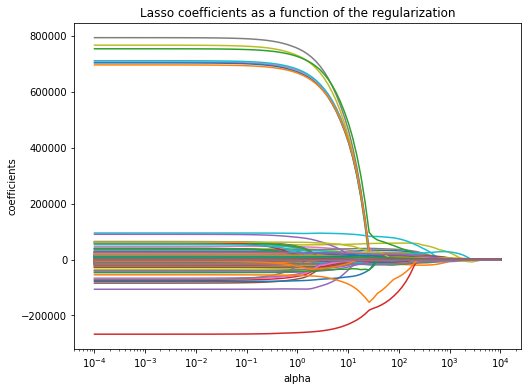

In [304]:
title = 'Lasso coefficients as a function of the regularization'
df_coef.plot(logx=True, title=title, legend=False)
plt.xlabel('alpha')
plt.ylabel('coefficients')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
#plt.axvline(x=model_lasso_5CV.alpha_,ls="dashed")
#plt.savefig('./lasso.png', bbox_inches='tight', dpi = 300)

In [305]:
beta_vals = pd.Series(model_lasso_5CV.coef_, index = X_train.columns)
beta_vals.head()

LotFrontage      -0.000000
LotArea           0.347368
YearBuilt       240.079056
YearRemodAdd    188.118910
MasVnrArea        9.281061
dtype: float64

In [250]:
print("Variables kept: " + str(sum(beta_vals != 0)))
print("Variables eliminated: " + str(sum(beta_vals == 0)))

Variables kept: 85
Variables eliminated: 260


### Important features

In [183]:
important_feat = pd.concat([beta_vals.sort_values().head(15), beta_vals.sort_values().tail(15)])

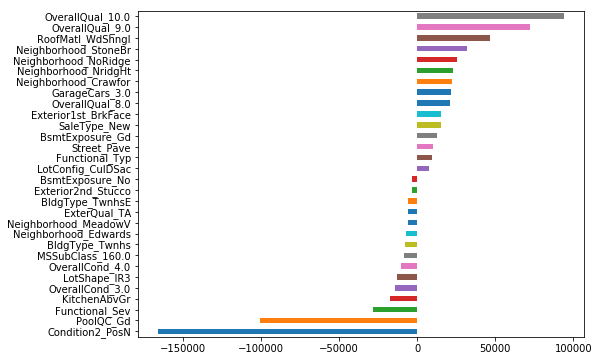

In [185]:
important_feat.plot(kind = "barh")
#plt.title("Coefficients in the Lasso Model")
plt.show()

### Plotting the actual vs expected house price 

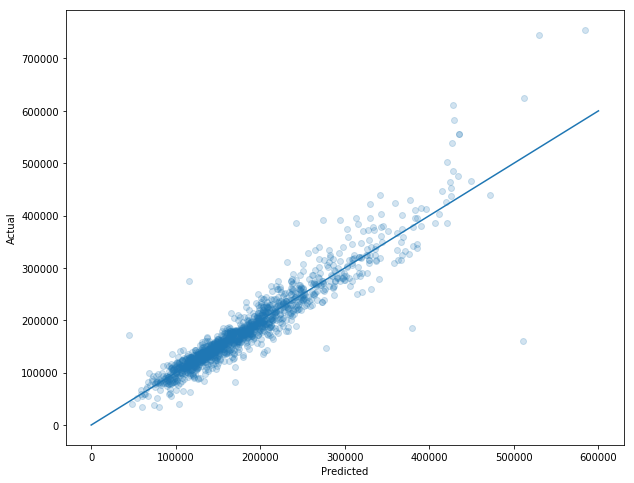

In [309]:
## Plotting the actual vs expected house price (along with the line x=y for reference)
plt.figure(figsize=(10,8))
plt.scatter(model_lasso_5CV.predict(X_train), y_train, alpha=.2)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))
plt.xlabel("Predicted")
plt.ylabel("Actual");

### Residual against predicted house price

Text(0,0.5,'Residual')

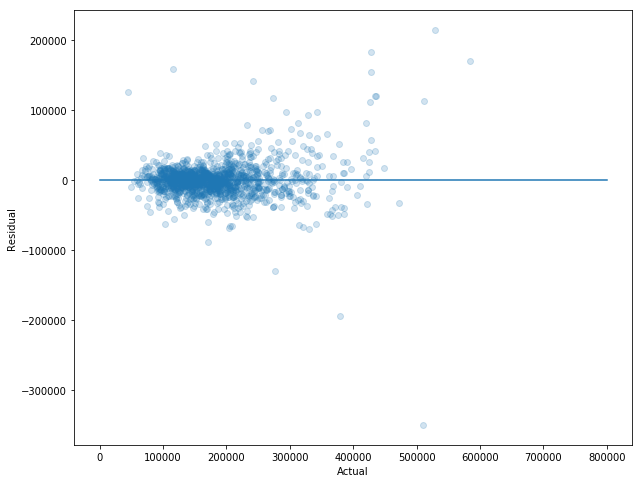

In [310]:
plt.figure(figsize=(10,8))
plt.scatter(model_lasso_5CV.predict(X_train), y_train - model_lasso_5CV.predict(X_train), alpha=.2)
plt.plot(np.linspace(0,800000,1000), np.linspace(0,0,1000))
plt.xlabel("Actual")
plt.ylabel("Residual")

### Creating submission output file

In [189]:
ID = test_ID
result = model_lasso_5CV.predict(X_test)

In [190]:
result[:10]

array([108980.06363563, 155193.33419629, 189334.18650846, 193879.64227921,
       210382.23988166, 175429.6928558 , 170046.68065017, 165408.8516834 ,
       198820.55153318, 123599.10273388])

In [191]:
#score from Kaggle's public leaderboard 0.14739
output = pd.DataFrame( { 'id': ID , 'SalePrice': result} )
output = output[['id', 'SalePrice']]

#output.to_csv("solution.csv", index = False)
output.head(10)

,id,SalePrice
0,1461,108980.063636
1,1462,155193.334196
2,1463,189334.186508
3,1464,193879.642279
4,1465,210382.239882
5,1466,175429.692856
6,1467,170046.680650
7,1468,165408.851683
8,1469,198820.551533
9,1470,123599.102734


### Tree-based models

In [203]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.fit(X_train, y_train)
train_error = (1 - randomForest.score(X_train, y_train))
#test_error = (1 - randomForest.score(X_test, y_test))
#print("The training error is: %.5f" %train_error)
#print("The test     error is: %.5f" %test_error)
print(randomForest.score(X_train, y_train))

0.9723526012704364


In [230]:
from sklearn.model_selection import train_test_split

In [311]:
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((1095, 345), (1095,), (365, 345), (365,))

In [313]:

from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor(random_state = 42)
randomForest.fit(x_tr, y_tr)
train_score =  randomForest.score(x_tr, y_tr)
val_score = randomForest.score(x_val, y_val)
total_score = randomForest.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

#train_error = (1 - randomForest.score(x_tr, y_tr))
#val_error = (1 - randomForest.score(x_val, y_val))
#total_error = (1 - randomForest.score(X_train, y_train))
#print("The training   error is: %.5f" %train_error)
#print("The validation error is: %.5f" %val_error)
#print("error running on total train data is: %.5f" %total_error)


The training   R^2 is: 0.96704
The validation R^2 is: 0.85231
R^2 for total train data is: 0.93519


In [314]:
feature_importance = list(zip(x_tr.columns, randomForest.feature_importances_))
feature_df = pd.DataFrame(feature_importance,columns = ['feature','importance']).sort_values('importance', ascending =False)
feature_df.head()

,feature,importance
17,TotalSF,0.666550
2,YearBuilt,0.045072
289,GarageCars_3.0,0.036345
5,BsmtFinSF1,0.018776
3,YearRemodAdd,0.018163


<BarContainer object of 20 artists>

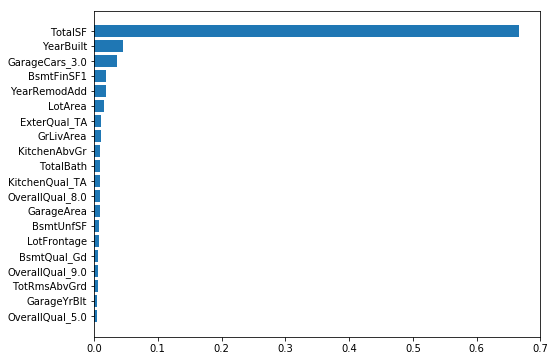

In [315]:
plt.barh(feature_df.feature[:20][::-1], feature_df.importance[:20][::-1])

In [324]:
randomForest = ensemble.RandomForestRegressor(oob_score  = True, random_state = 42) #oob did not make any difference
randomForest.fit(x_tr, y_tr)
train_score =  randomForest.score(x_tr, y_tr)
val_score = randomForest.score(x_val, y_val)
total_score = randomForest.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

The training   R^2 is: 0.96704
The validation R^2 is: 0.85231
R^2 for total train data is: 0.93519


/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [322]:
randomForest = ensemble.RandomForestRegressor(n_estimators =100,  random_state = 42) 
randomForest.fit(x_tr, y_tr)
train_score =  randomForest.score(x_tr, y_tr)
val_score = randomForest.score(x_val, y_val)
total_score = randomForest.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

The training   R^2 is: 0.97612
The validation R^2 is: 0.87393
R^2 for total train data is: 0.94775


In [321]:
randomForest = ensemble.RandomForestRegressor(n_estimators =100, oob_score  = True, random_state = 42) #oob did not make any difference
randomForest.fit(x_tr, y_tr)
train_score =  randomForest.score(x_tr, y_tr)
val_score = randomForest.score(x_val, y_val)
total_score = randomForest.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

The training   R^2 is: 0.97612
The validation R^2 is: 0.87393
R^2 for total train data is: 0.94775


### Grid search

In [337]:
'''
grid_para_forest = [{
    "n_estimators": [25, 50, 100], #The number of trees in the forest
    "min_samples_leaf": range(1, 10), #The minimum number of samples required to be at a leaf node
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int), #The minimum number of samples required to split an internal node
    "random_state": [42]
}]
grid_search_forest_5CV = GridSearchCV(randomForest, grid_para_forest, cv=5, n_jobs=-1)
'''

In [333]:
from sklearn.model_selection import GridSearchCV
grid_para_forest = [{"n_estimators": [ 100]}]
grid_search_forest = GridSearchCV(randomForest, param_grid = grid_para_forest, n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

CPU times: user 3.52 s, sys: 315 ms, total: 3.84 s
Wall time: 7.42 s


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [334]:
train_score =  grid_search_forest.score(x_tr, y_tr)
val_score = grid_search_forest.score(x_val, y_val)
total_score = grid_search_forest.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

The training   R^2 is: 0.97718
The validation R^2 is: 0.98347
R^2 for total train data is: 0.97893


In [335]:
grid_search_forest_5CV = GridSearchCV(randomForest, param_grid = grid_para_forest, cv =5, n_jobs=-1)
%time grid_search_forest_5CV.fit(X_train, y_train)

CPU times: user 3.58 s, sys: 91.8 ms, total: 3.67 s
Wall time: 11.3 s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [336]:
train_score =  grid_search_forest_5CV.score(x_tr, y_tr)  #cross-validation did not improve
val_score = grid_search_forest_5CV.score(x_val, y_val)
total_score = grid_search_forest_5CV.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

The training   R^2 is: 0.97718
The validation R^2 is: 0.98347
R^2 for total train data is: 0.97893


In [339]:
grid_para_forest = [{
    "n_estimators": [25, 50, 100], #The number of trees in the forest
    "min_samples_leaf": range(1, 10), #The minimum number of samples required to be at a leaf node
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int), #The minimum number of samples required to split an internal node
    "random_state": [42]
}]
grid_search_forest_5CV = GridSearchCV(randomForest, grid_para_forest, cv=5, n_jobs=-1)
%time grid_search_forest_5CV.fit(X_train, y_train)

CPU times: user 11.5 s, sys: 2.91 s, total: 14.4 s
Wall time: 15min 10s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'min_samples_leaf': range(1, 10), 'random_state': [42], 'n_estimators': [25, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [340]:
train_score =  grid_search_forest_5CV.score(x_tr, y_tr)  #cross-validation did not improve
val_score = grid_search_forest_5CV.score(x_val, y_val)
total_score = grid_search_forest_5CV.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

The training   R^2 is: 0.95911
The validation R^2 is: 0.96418
R^2 for total train data is: 0.96053


In [341]:
ID = test_ID
result = grid_search_forest_5CV.predict(X_test)
#score from Kaggle's public leaderboard: 0.15828
output = pd.DataFrame( { 'id': ID , 'SalePrice': result} )
output = output[['id', 'SalePrice']]

output.to_csv("solution.csv", index = False)
output.head(10)

,id,SalePrice
0,1461,122428.035470
1,1462,159391.953143
2,1463,190263.437691
3,1464,191949.466580
4,1465,201466.368857
5,1466,178989.095152
6,1467,174646.154055
7,1468,174948.826025
8,1469,193142.993333
9,1470,132065.952670
